In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import match_template
from skimage.measure import label, find_contours

In [279]:
img1 = cv.imread('train/template_2.jpg')#,cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('train/train_2.jpg')#,cv.IMREAD_GRAYSCALE) # trainImage

In [280]:
img1.shape

(259, 217, 3)

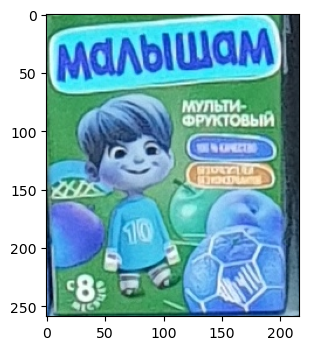

In [281]:
padd = img1.shape[0] // 10
plt.figure(dpi=100)
plt.imshow(img1, cmap='gray')

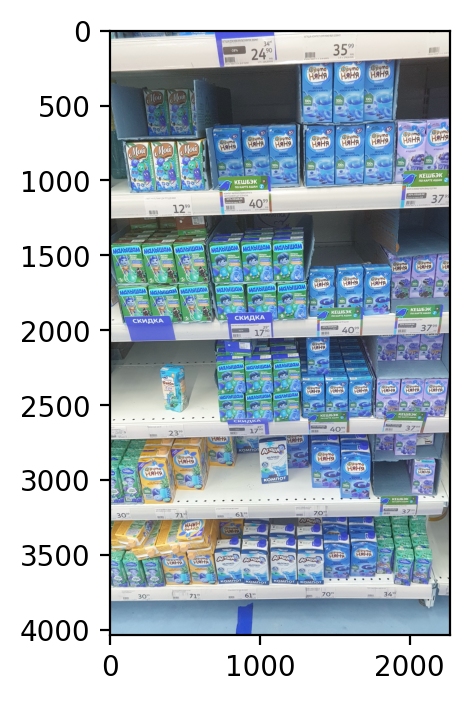

In [282]:
plt.figure(dpi=200)
plt.imshow(img2, cmap='gray')

In [283]:
import cv2 as cv
import numpy as np
from skimage.feature import match_template
from skimage.measure import label, find_contours


def plot_rectangles(img, points, bbox_shape, k=2):
    points = np.int16(points)
    res_img = np.int16(img.copy())
    for pt in points:
        cv.rectangle(res_img, (pt[0] - bbox_shape[1] // k, pt[1] - bbox_shape[0] // k),
                      (pt[0] + bbox_shape[1] // k, pt[1] + bbox_shape[0] // k), 255, -1)
    return res_img

def get_local_centers(corr, th):
    lbl, n = label(corr >= th, connectivity=2, return_num=True)
    return np.int16([np.round(np.mean(np.argwhere(lbl == i), axis=0)) for i in range(1, n + 1)])

In [284]:
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY).copy()
img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY).copy()

In [285]:
padd = img1.shape[0] // 10
cutoff = img1[3*padd:-3*padd, padd:-padd]

sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(cutoff,None)
kp2, des2 = sift.detectAndCompute(img2,None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des2, des1, k=2)
good = []
for t in matches:
    for i in range(len(t)-1):
        if t[i].distance < 0.5*t[i+1].distance:
            good.append([t[i]])

In [286]:
list_kp2 = []

for mat in good:
    img2_idx = mat[0].queryIdx
    p2 = kp2[img2_idx]
    list_kp2.append(p2)

img3 = cv.drawKeypoints(img2, tuple(list_kp2), None, color=255)

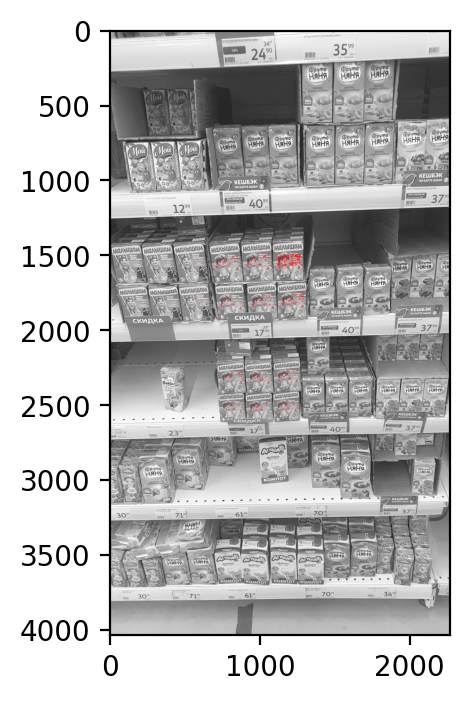

In [287]:
plt.figure(dpi=200)
plt.imshow(img3)

In [288]:
img3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)

In [289]:
list_kp2 = []

for mat in good:
    img2_idx = mat[0].queryIdx
    (x2, y2) = kp2[img2_idx].pt
    list_kp2.append((x2, y2))

In [290]:
mask = np.zeros_like(img3)
res = plot_rectangles(mask, list_kp2, cutoff.shape, k=6)

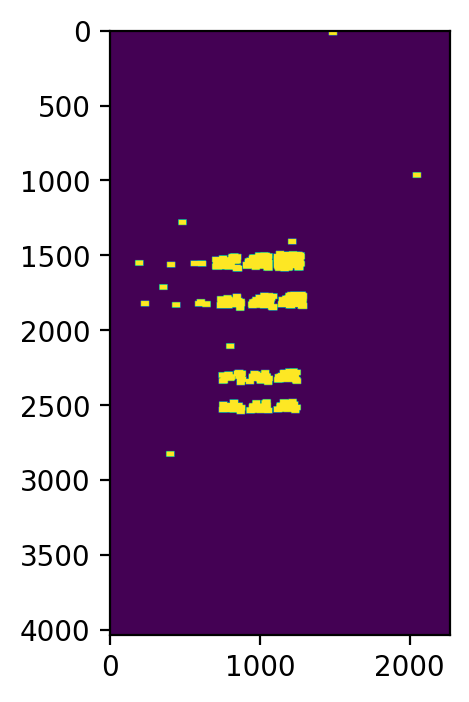

In [291]:
plt.figure(dpi=200)
plt.imshow(res, cmap=None)

In [292]:
lbl, n = label(res > 1, connectivity=2, return_num=True)
areas = np.array([np.sum(lbl==i) for i in range(1,len(np.unique(lbl)))])
min_area = np.max([cutoff.shape[0] * cutoff.shape[1] / 4, np.min(areas)])
filt = areas > min_area
labels_left = np.unique(lbl)[1:][filt]
lbl = lbl * (np.isin(lbl, labels_left))
points = np.int16([np.round(np.mean(np.argwhere(lbl == i), axis=0)) for i in labels_left])
points = np.int16(points)[::, ::-1]

In [293]:
bboxes_list = []
for pt in points:
    xmin, ymin = (pt[0] - img1.shape[1] // 2, pt[1] - img1.shape[0] // 2)
    xmin, ymin = xmin, ymin
    width, height = img1.shape[1], img1.shape[0]
    bboxes_list.append((xmin, ymin, width, height))

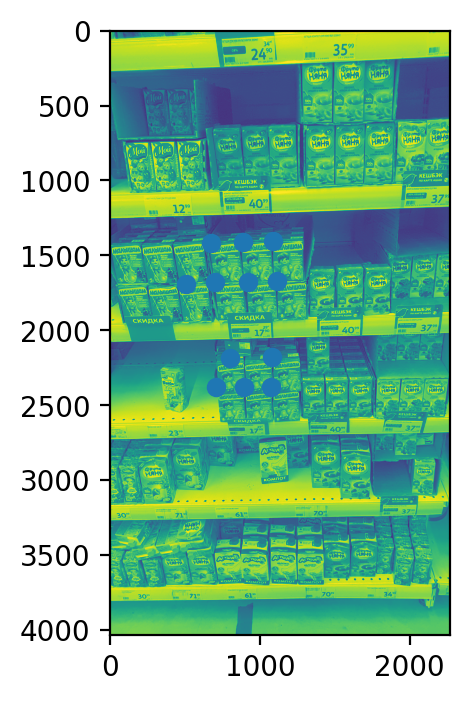

In [294]:
plt.figure(dpi=200)
plt.imshow(img2)
plt.scatter(np.array(bboxes_list)[:, 0], np.array(bboxes_list)[:, 1])